# CSE 252A Computer Vision I Fall 2017
## Assignment 4

## Problem 1: Install Tensorflow [2 pts]
Follow the directions on https://www.tensorflow.org/install/ to install Tensorflow on your computer.

Note: You will not need GPU support for this assignment so don't worry if you don't have one. Furthermore, installing with GPU support is often more difficult to configure so it is suggested that you install the CPU only version. However, if you have a GPU and would like to install GPU support feel free to do so at your own risk :)

Note: On windows, Tensorflow is only supported in python3, so you will need to install python3 for this assignment.

Run the following cell to verify your instalation.

In [1]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

Hello, TensorFlow!


## Problem 2: Downloading CIFAR10 [1 pts]
Download the CIFAR10 dataset (http://www.cs.toronto.edu/~kriz/cifar.html). You will need the python version: http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 

Extract the data to ./data
Once extracted run the following cell to view a few example images.

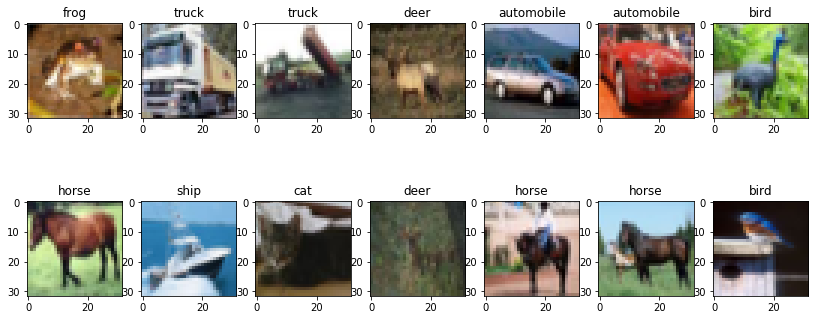

train shape: (50000, 32, 32, 3), (50000,)
test shape : (10000, 32, 32, 3), (10000,)


In [21]:
import numpy as np

# unpickles raw data files
def unpickle(file):
    import pickle
    import sys
    with open(file, 'rb') as fo:
        if sys.version_info[0] < 3:
            dict = pickle.load(fo)
        else:
           dict = pickle.load(fo, encoding='bytes') 
    return dict

# loads data from a single file
def getBatch(file):
    dict = unpickle(file)
    data = dict[b'data'].reshape(-1,3,32,32).transpose(0,2,3,1)
    labels = np.asarray(dict[b'labels'], dtype=np.int64)
    return data,labels

# loads all training and testing data
def getData(path='./data'):
    classes = [s.decode('UTF-8') for s in unpickle(path+'/batches.meta')[b'label_names']]
    
    trainData, trainLabels = [], []
    for i in range(5):
        data, labels = getBatch(path+'/data_batch_%d'%(i+1))
        trainData.append(data)
        trainLabels.append(labels)
    trainData = np.concatenate(trainData)
    trainLabels = np.concatenate(trainLabels)
    
    testData, testLabels = getBatch(path+'/test_batch')
    return classes, trainData, trainLabels, testData, testLabels

# training and testing data that will be used in the following problems
classes, trainData, trainLabels, testData, testLabels = getData()

# display some example images
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14, 6))
for i in range(14):
    plt.subplot(2,7,i+1)
    plt.imshow(trainData[i])
    plt.title(classes[trainLabels[i]])
plt.show()

print ('train shape: ' + str(trainData.shape) + ', ' + str(trainLabels.shape))
print ('test shape : ' + str(testData.shape) + ', ' + str(testLabels.shape))

Below are some helper functions that will be used in the following problems.

In [3]:
# a generator for batches of data
# yields data (batchsize, 3, 32, 32) and labels (batchsize)
# if shuffle, it will load batches in a random order
def DataBatch(data, label, batchsize, shuffle=True):
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

# tests the accuracy of a classifier
def test(testData, testLabels, classifier):
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize):
        prediction = classifier(data)
        #print (prediction)
        correct += np.sum(prediction==label)
    return correct/testData.shape[0]*100

# a sample classifier
# given an input it outputs a random class
class RandomClassifier():
    def __init__(self, classes=10):
        self.classes=classes
    def __call__(self, x):
        return np.random.randint(self.classes, size=x.shape[0])

randomClassifier = RandomClassifier()
print ('Random classifier accuracy: %f'%test(testData, testLabels, randomClassifier))

Random classifier accuracy: 9.940000


## Problem 3: Confusion Matirx [5 pts]
Here you will implement a test script that computes the confussion matrix for a classifier.
The matrix should be nxn where n is the number of classes.
Entry M[i,j] should contain the number of times an image of class i was classified as class j.
M should be normalized such that each row sums to 1.

Hint: see the function test() above for reference.

In [4]:
def confusion(testData, testLabels, classifier):
    n= len(set(testLabels))
    M = np.zeros((n,n))
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize):
        prediction = classifier(data)
        M[label,prediction] += 1
    M = M/sum(M)[:, None]    
    return M


def VisualizeConfussion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)#, vmin=0, vmax=1)
    plt.xticks(np.arange(len(classes)), classes, rotation='vertical')
    plt.yticks(np.arange(len(classes)), classes)
    plt.show()

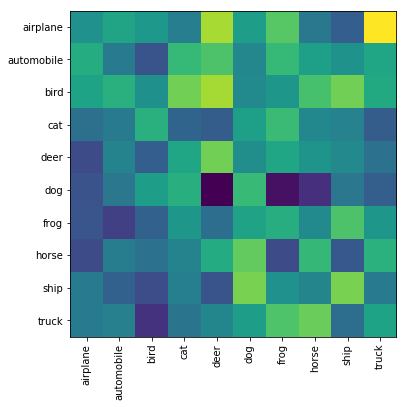

In [9]:
M = confusion(testData, testLabels, randomClassifier)
VisualizeConfussion(M)

## Problem 4: K-Nearest Neighbors (KNN) [5 pts]
Here you will implemnet a simple knn classifer. The distance metric is euclidian in pixel space. k refers to the number of neighbors involved in voting on the class.

Hint: you may want to use: sklearn.neighbors.KNeighborsClassifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier
class KNNClassifer():
    def __init__(self, k=3):
        # k is the number of neighbors involved in voting
        """your code here, weights=’uniform , algorithm=’auto’,"""
        self.knn = KNeighborsClassifier(n_neighbors=k,metric='minkowski',p=2)
        
        
    def transform(self, data):
        s = data.shape
        #print s
        return data.reshape(s[0], s[1]*s[2]*s[3])
    
    def train(self, trainData, trainLabels):
        tdata = self.transform(trainData)
        self.knn.fit(tdata, trainLabels)
        
    def __call__(self, x):
        # this method should take a batch of images (batchsize, 32, 32, 3) and return a batch of prediction (batchsize)
        # predictions should be int64 values in the range [0,9] corrisponding to the class that the image belongs to
        """your code here"""
        testData = self.transform(x)
        predictions = self.knn.predict(testData)
        return predictions

In [14]:
# test your classifier with only the first 100 training examples (use this while debugging)
# note you should get around 10-20% accuracy
knnClassiferX = KNNClassifer()
knnClassiferX.train(trainData[:100], trainLabels[:100])
print ('KNN classifier accuracy: %f'%test(testData, testLabels, knnClassiferX))

KNN classifier accuracy: 16.600000


KNN classifier accuracy: 33.030000


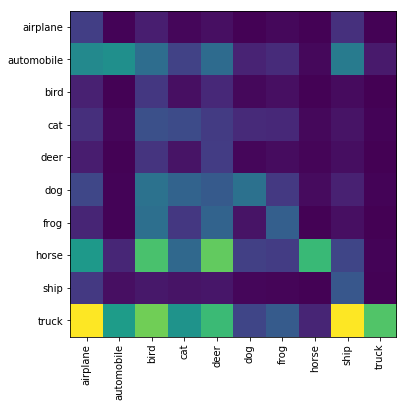

In [15]:
# test your classifier with all the training examples (This may take a while)
# note you should get around 30% accuracy
knnClassifer = KNNClassifer()
knnClassifer.train(trainData, trainLabels)
print ('KNN classifier accuracy: %f'%test(testData, testLabels, knnClassifer))

# display confusion matrix for your KNN classifier with all the training examples
M = confusion(testData, testLabels, knnClassifer)
VisualizeConfussion(M)

## Problem 5: Principal Component Analysis (PCA) K-Nearest Neighbors (KNN) [5 pts]
Here you will implemnet a simple knn classifer in PCA space.
You should implement PCA yourself using svd (you may not use sklearn.decomposition.PCA
or any other package that directly implements PCA transofrmations

Hint: Don't forget to apply the same normalization at test time.

Note: you should get similar accuracy to above, but it should run faster.

In [82]:
from sklearn.decomposition import PCA
class PCAKNNClassifer():
    def __init__(self, components=25, k=3):
        """your code here"""
        self.components = components
        self.knn = KNeighborsClassifier(n_neighbors=k,metric='minkowski',p=2)
        
    def transform(self, data):
        s = data.shape
        return data.reshape(s[0], s[1]*s[2]*s[3])    
     
    def getEigenValues(self, data):
        mean = data.mean(0)
        d = len(data[0])
        scatter_matrix = np.zeros((d,d))
        for i in range(len(data)):
            sample = np.array(data[i])
            scatter_matrix += (sample - mean).T.dot((sample - mean))
        #print('Scatter Matrix:\n', scatter_matrix)
        eig_val_sc, eig_vec_sc = np.linalg.eigh(scatter_matrix)

        eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        return eig_pairs, mean

    def compressor(self, data, eig_pairs):
        matrix_w = []
        for i in range(self.components):
            matrix_w.append(eig_pairs[i][1])
        matrix_w = np.matrix(matrix_w)
        matrix_w = matrix_w.T

        data = np.matrix(data)
        data = data - self.mean
        tdata = data.dot(matrix_w)
        self.matrix_w = matrix_w
        return tdata
    
    def pcaTransform(self, data):
        ep, mu = self.getEigenValues(data)
        self.mean = mu
        data = self.compressor(data, ep)
        return data
        
    def train(self, trainData, trainLabels):
        """your code here"""
        trainData = self.transform(trainData)
        trainData = self.pcaTransform(trainData)
        self.knn.fit(trainData, trainLabels)
              
    def __call__(self, x):
        """your code here"""
        testData = self.transform(x)
        testData = testData - self.mean
        testData = testData.dot(self.matrix_w)
        predictions = self.knn.predict(testData)
        return predictions

In [86]:
# test your classifier with only the first 100 training examples (use this while debugging)
pcaknnClassiferX = PCAKNNClassifer(75,10)
pcaknnClassiferX.train(trainData[:200], trainLabels[:200])
print ('PCA-KNN classifier accuracy: %f'%test(testData, testLabels, pcaknnClassiferX))

PCA-KNN classifier accuracy: 17.090000


KNN classifier accuracy: 30.280000


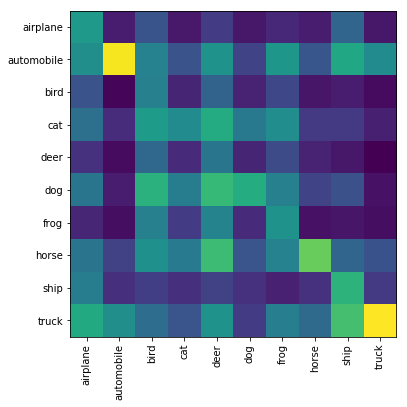

In [101]:
# test your classifier with all the training examples (This may take a few minutes)
pcaknnClassifer = PCAKNNClassifer(75,10)
pcaknnClassifer.train(trainData, trainLabels)
print ('KNN classifier accuracy: %f'%test(testData, testLabels, pcaknnClassifer))

# display the confusion matrix
M = confusion(testData, testLabels, pcaknnClassifer)
VisualizeConfussion(M)

## Deep learning
Below is some helper code to train your deep networks

Hint: see https://www.tensorflow.org/get_started/mnist/pros or https://www.tensorflow.org/get_started/mnist/beginners for reference

In [11]:
# base class for your Tensorflow networks. It implements the training loop (train) and prediction(__call__)  for you.
# You will need to implement the __init__ function to define the networks structures in the following problems
class TFClassifier():
    def __init__(self):
        pass
    
    def train(self, trainData, trainLabels, epochs=1, batchsize=50):
        self.prediction = tf.argmax(self.y,1)
        self.cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y_, logits=self.y))
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
        self.correct_prediction = tf.equal(self.prediction, self.y_)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
        self.sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for i, (data,label) in enumerate(DataBatch(trainData, trainLabels, batchsize, shuffle=True)):
                _, acc = self.sess.run([self.train_step, self.accuracy], feed_dict={self.x: data, self.y_: label})
                #if i%100==99:
                #    print ('%d/%d %d %f'%(epoch, epochs, i, acc))
                    
            print ('testing epoch:%d accuracy: %f'%(epoch+1, test(testData, testLabels, self)))
        
    def __call__(self, x):
        return self.sess.run(self.prediction, feed_dict={self.x: x})

# helper function to get weight variable
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

# helper function to get bias variable
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# example linear classifier
class LinearClassifer(TFClassifier):
    def __init__(self, classes=10):
        self.sess = tf.Session()

        self.x = tf.placeholder(tf.float32, shape=[None,32,32,3]) # input batch of images
        self.y_ = tf.placeholder(tf.int64, shape=[None]) # input labels

        # model variables
        self.W = weight_variable([32*32*3,classes])
        self.b = bias_variable([classes])

        # linear operation
        self.y = tf.matmul(tf.reshape(self.x,(-1,32*32*3)),self.W) + self.b

testing epoch:1 accuracy: 25.360000
testing epoch:2 accuracy: 26.710000
testing epoch:3 accuracy: 23.980000
testing epoch:4 accuracy: 24.880000
testing epoch:5 accuracy: 30.360000
testing epoch:6 accuracy: 20.810000
testing epoch:7 accuracy: 28.460000
testing epoch:8 accuracy: 25.530000
testing epoch:9 accuracy: 30.370000
testing epoch:10 accuracy: 25.580000
testing epoch:11 accuracy: 28.600000
testing epoch:12 accuracy: 29.330000
testing epoch:13 accuracy: 27.910000
testing epoch:14 accuracy: 26.030000
testing epoch:15 accuracy: 26.200000
testing epoch:16 accuracy: 25.870000
testing epoch:17 accuracy: 24.610000
testing epoch:18 accuracy: 28.900000
testing epoch:19 accuracy: 30.600000
testing epoch:20 accuracy: 23.960000


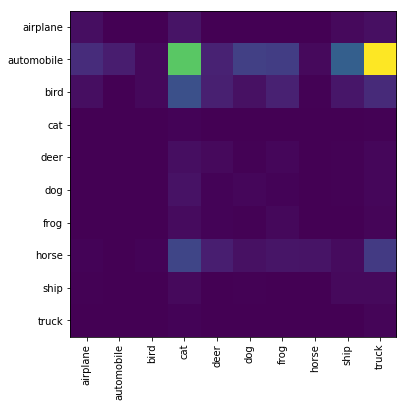

In [12]:
# test the example linear classifier (note you should get around 20-30% accuracy)
linearClassifer = LinearClassifer()
linearClassifer.train(trainData, trainLabels, epochs=20)

# display confusion matrix
M = confusion(testData, testLabels, linearClassifer)
VisualizeConfussion(M)

## Problem 6: Multi Layer Perceptron (MLP) [5 pts]
Here you will implement an MLP. The MLP shoud consist of 3 linear layers (matrix multiplcation and bias offset) that map to the following feature dimensions:

32x32x3 -> hidden

hidden -> hidden

hidden -> classes

The first two linear layers should be followed with a ReLU nonlinearity. The final layer should not have a nonlinearity applied as we desire the raw logits output (see: the documentation for tf.nn.sparse_softmax_cross_entropy_with_logits used in the training)

The final output of the computation graph should be stored in self.y as that will be used in the training.

Hint: see the example linear classifier

Note: you should get around 50% accuracy

In [34]:
class MLPClassifer(TFClassifier):
    def __init__(self, classes=10, hidden=100):
        self.sess = tf.Session()

        self.x = tf.placeholder(tf.float32, shape=[None,32,32,3]) # input batch of images
        self.y_ = tf.placeholder(tf.int64, shape=[None]) # input labels

        """your code here"""
        # model variables
        self.W1 = weight_variable([32*32*3,100])
        self.W2 = weight_variable([100,100])
        self.W3 = weight_variable([100,classes])
        self.b1 = bias_variable([100])
        self.b2 = bias_variable([100])
        self.b3 = bias_variable([classes])

        #model
        v1 = tf.nn.relu(tf.matmul(tf.reshape(self.x,(-1,32*32*3)),self.W1) + self.b1)
        v2 = tf.nn.relu(tf.matmul(v1,self.W2) + self.b2)
        v3 = tf.matmul(v2,self.W3) + self.b3
        self.y = v3

testing epoch:1 accuracy: 39.470000
testing epoch:2 accuracy: 43.040000
testing epoch:3 accuracy: 44.540000
testing epoch:4 accuracy: 44.470000
testing epoch:5 accuracy: 45.740000
testing epoch:6 accuracy: 46.200000
testing epoch:7 accuracy: 47.180000
testing epoch:8 accuracy: 48.230000
testing epoch:9 accuracy: 47.840000
testing epoch:10 accuracy: 49.460000
testing epoch:11 accuracy: 49.250000
testing epoch:12 accuracy: 49.250000
testing epoch:13 accuracy: 48.120000
testing epoch:14 accuracy: 49.990000
testing epoch:15 accuracy: 49.450000
testing epoch:16 accuracy: 49.990000
testing epoch:17 accuracy: 50.170000
testing epoch:18 accuracy: 50.300000
testing epoch:19 accuracy: 50.070000
testing epoch:20 accuracy: 48.920000


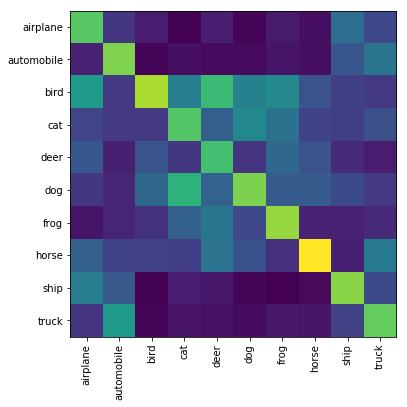

In [39]:
# test your MLP classifier (note you should get around 50% accuracy)
mlpClassifer = MLPClassifer()
mlpClassifer.train(trainData, trainLabels, epochs=20)

# display confusion matrix
M = confusion(testData, testLabels, mlpClassifer)
VisualizeConfussion(M)

## Problem 7: Convolutional Neural Netork (CNN) [7 pts]
Here you will implement a CNN with the following architecture:

ReLU( Conv(kernel_size=4x4 stride=2, output_features=n) )

ReLU( Conv(kernel_size=4x4 stride=2, output_features=n*2) )

ReLU( Conv(kernel_size=4x4 stride=2, output_features=n*4) )

Linear(output_features=classes)

In [12]:
def conv2d(x, W, stride=2):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

class CNNClassifer(TFClassifier):
    def __init__(self, classes=10, n=16):
        self.sess = tf.Session()

        self.x = tf.placeholder(tf.float32, shape=[None,32,32,3]) # input batch of images
        self.y_ = tf.placeholder(tf.int64, shape=[None]) # input labels

        """your code here"""
        # model variables
        #stride = 2
        #out_height = ceil(float(32) / float(strides[1]))
        #out_width  = ceil(float(32) / float(strides[2]))

        stride1 = 1
        stride2 = 2
        stride3 = 2
        poolStride = 2
        finalWidth = 32/(stride1*stride2*stride3)
        
        self.W1 = tf.Variable(tf.random_normal([4,4,3,n]))
        self.W2 = tf.Variable(tf.random_normal([4,4,n,n*2]))
        self.W3 = tf.Variable(tf.random_normal([4,4,n*2,n*4]))
        self.W4 = weight_variable([n*4*finalWidth*finalWidth,classes])
        self.b4 = bias_variable([classes])
        #self.W5 = weight_variable([n*2,classes])
        #self.b5 = bias_variable([classes])
        
        #model
        c1 = conv2d(self.x,self.W1, stride1)
        v1 = tf.nn.relu(c1)
        print v1.shape
        c2 = conv2d(v1,self.W2, stride2)
        v2 = tf.nn.relu(c2)
        print v2.shape
        c3 = conv2d(v2,self.W3, stride3)
        v3 = tf.nn.relu(c3)
        print v3.shape
        f  =  tf.reshape(v3, [-1, finalWidth*finalWidth*n*4])
        print f.shape, n*4*finalWidth*finalWidth
        v4 = tf.matmul(f,self.W4) + self.b4
        self.y = v4

(?, 32, 32, 256)
(?, 16, 16, 512)
(?, 8, 8, 1024)
(?, 65536) 65536


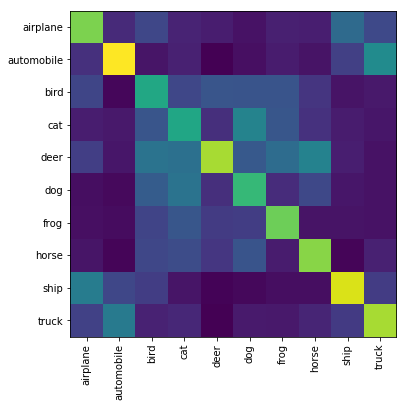

In [32]:
# test your CNN classifier (note you should get around 65% accuracy)
cnnClassifer = CNNClassifer(10, 256)
cnnClassifer.train(trainData, trainLabels, epochs=50)

# display confusion matrix
M = confusion(testData, testLabels, cnnClassifer)
VisualizeConfussion(M)

In [33]:
""" Copied comments from my other machine


testing epoch:1 accuracy: 40.930000                                             
testing epoch:2 accuracy: 44.900000                                             
testing epoch:3 accuracy: 44.880000
testing epoch:4 accuracy: 46.980000
testing epoch:5 accuracy: 50.620000
testing epoch:6 accuracy: 50.590000
testing epoch:7 accuracy: 52.160000
testing epoch:8 accuracy: 53.840000
testing epoch:9 accuracy: 54.440000
testing epoch:10 accuracy: 53.580000
testing epoch:11 accuracy: 54.460000
testing epoch:12 accuracy: 54.270000
testing epoch:13 accuracy: 54.450000
testing epoch:14 accuracy: 55.090000
testing epoch:15 accuracy: 55.660000
testing epoch:16 accuracy: 55.180000
testing epoch:17 accuracy: 55.740000
testing epoch:18 accuracy: 56.350000
testing epoch:19 accuracy: 56.020000
testing epoch:20 accuracy: 56.740000
testing epoch:21 accuracy: 56.250000
testing epoch:22 accuracy: 56.280000
testing epoch:23 accuracy: 56.500000
testing epoch:24 accuracy: 56.160000
testing epoch:25 accuracy: 56.840000
testing epoch:26 accuracy: 57.150000
testing epoch:27 accuracy: 57.120000
testing epoch:28 accuracy: 56.810000
testing epoch:29 accuracy: 56.700000
testing epoch:30 accuracy: 56.750000
testing epoch:31 accuracy: 57.050000                                                                                                 testing epoch:32 accuracy: 57.110000                                                                                                 testing epoch:33 accuracy: 57.710000
testing epoch:34 accuracy: 57.260000
testing epoch:35 accuracy: 57.600000
testing epoch:36 accuracy: 56.580000
testing epoch:37 accuracy: 57.260000
testing epoch:38 accuracy: 57.690000
testing epoch:39 accuracy: 56.880000
testing epoch:40 accuracy: 57.310000
testing epoch:41 accuracy: 56.230000
testing epoch:42 accuracy: 57.230000
testing epoch:43 accuracy: 57.570000
testing epoch:44 accuracy: 57.380000
testing epoch:45 accuracy: 57.380000
testing epoch:46 accuracy: 57.280000
testing epoch:47 accuracy: 57.560000
testing epoch:48 accuracy: 57.130000
testing epoch:49 accuracy: 57.470000
testing epoch:50 accuracy: 57.480000"""

' Copied comments from my other machine\n\n\ntesting epoch:1 accuracy: 40.930000                                             \ntesting epoch:2 accuracy: 44.900000                                             \ntesting epoch:3 accuracy: 44.880000\ntesting epoch:4 accuracy: 46.980000\ntesting epoch:5 accuracy: 50.620000\ntesting epoch:6 accuracy: 50.590000\ntesting epoch:7 accuracy: 52.160000\ntesting epoch:8 accuracy: 53.840000\ntesting epoch:9 accuracy: 54.440000\ntesting epoch:10 accuracy: 53.580000\ntesting epoch:11 accuracy: 54.460000\ntesting epoch:12 accuracy: 54.270000\ntesting epoch:13 accuracy: 54.450000\ntesting epoch:14 accuracy: 55.090000\ntesting epoch:15 accuracy: 55.660000\ntesting epoch:16 accuracy: 55.180000\ntesting epoch:17 accuracy: 55.740000\ntesting epoch:18 accuracy: 56.350000\ntesting epoch:19 accuracy: 56.020000\ntesting epoch:20 accuracy: 56.740000\ntesting epoch:21 accuracy: 56.250000\ntesting epoch:22 accuracy: 56.280000\ntesting epoch:23 accuracy: 56.500000\n